## 1- Import Libraries and modules

In [72]:
import numpy as np
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2
import os
import random
import shutil
import joblib
import pickle
from google.colab.patches import cv2_imshow
from google.colab import files


from keras.models import model_from_json
from keras import models, layers, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from keras import optimizers




In [1]:
!pip install kaggle


## 2- Access Dataset on Kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mhmod01110","key":"69eb531ee1b2d7a8cd07036386846b90"}'}

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle competitions download -c state-farm-distracted-driver-detection

100% 3.99G/4.00G [00:35<00:00, 118MB/s]
100% 4.00G/4.00G [00:35<00:00, 122MB/s]


In [6]:
!unzip -q /content/state-farm-distracted-driver-detection.zip


In [7]:
pwd

'/content'

## 3- Read sample image and show it to ensure correct importing from kaggle

Image shape: (480, 640, 3)
Image data type: uint8


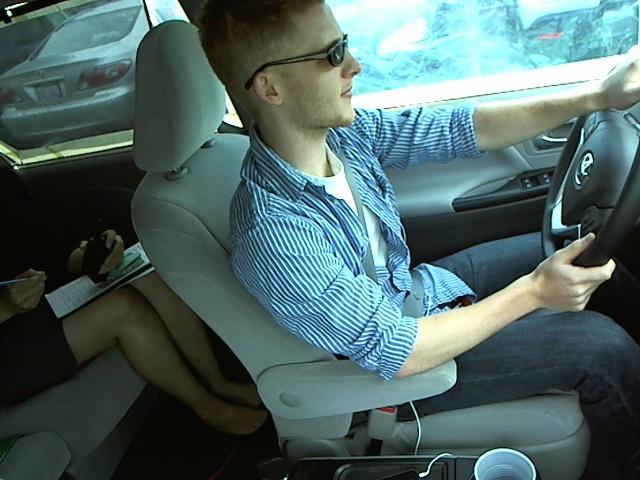

In [8]:
# Read an image
img = cv2.imread("/content/imgs/train/c0/img_100026.jpg")

# Check if the image was loaded successfully
if img is None:
    print("Error: Unable to load image.")
else:
    # Display basic information about the image
    print("Image shape:", img.shape)
    print("Image data type:", img.dtype)

    # Display the image
    cv2_imshow(img)


## 4- Some manual steps to train test split and manual labeling (will all automatically handeled by keras library)

In [9]:
def create_labels(path_list):
    labels = []
    i = 0
    for path_sub in path_list:
      labels_sub = np.full(len(path_sub), i)
      labels.append(labels_sub)
      i += 1
    return labels

In [10]:
# Define the directory containing images
directory = "/content/imgs/train/"

# Create a list to store lists of image paths for each class
class_image_paths = []

# Iterate over each class (c0 to c9)
for i in range(10):
    class_dir = os.path.join(directory, "c" + str(i))
    # Get the list of image file names in the class directory
    image_files = os.listdir(class_dir)
    # Construct the full paths to each image and append them to the class_image_paths list
    class_image_paths.append([os.path.join(class_dir, img) for img in image_files])

# Print the first few paths in each class for verification
for i, class_paths in enumerate(class_image_paths):
    # print(f"Class c{i}: {class_paths[:5]}")
    print(f"Class c{i}: {len(class_paths)}")

Class c0: 2489
Class c1: 2267
Class c2: 2317
Class c3: 2346
Class c4: 2326
Class c5: 2312
Class c6: 2325
Class c7: 2002
Class c8: 1911
Class c9: 2129


In [11]:
test_data = []
# Iterate over each class's image paths
for class_paths in class_image_paths:
    # Calculate the number of paths to select for test data (20% of the total paths)
    num_test_paths = int(0.2 * len(class_paths))
    # Randomly select paths for test data
    test_paths = random.sample(class_paths, num_test_paths)
    # Append the selected test paths to the test_data list
    test_data.append(test_paths)

# Print the first few paths in the test data for each class for verification
for i, class_test_paths in enumerate(test_data):
    print(f"Class c{i} test data: {len(class_test_paths)}")

Class c0 test data: 497
Class c1 test data: 453
Class c2 test data: 463
Class c3 test data: 469
Class c4 test data: 465
Class c5 test data: 462
Class c6 test data: 465
Class c7 test data: 400
Class c8 test data: 382
Class c9 test data: 425


In [12]:
train_labels = create_labels(class_image_paths)
test_labels = create_labels(test_data)

In [13]:
len(train_labels) == len(class_image_paths) == len(test_data) == len(test_labels)

True

In [14]:
# Define directories
train_dir = "/content/imgs/train/"
validation_dir = "/content/imgs/validation/"

# Create validation directory if it doesn't exist
if not os.path.exists(validation_dir):
    os.makedirs(validation_dir)

# Iterate over each class (c0 to c9)
for i in range(10):
    class_train_dir = os.path.join(train_dir, "c" + str(i))
    class_validation_dir = os.path.join(validation_dir, "c" + str(i))

    # Create class validation directory if it doesn't exist
    if not os.path.exists(class_validation_dir):
        os.makedirs(class_validation_dir)

    # Get list of images in the training directory for the current class
    images = os.listdir(class_train_dir)
    # Calculate 20% of the images
    num_validation_images = int(0.2 * len(images))
    # Randomly select 20% of the images for validation
    validation_images = random.sample(images, num_validation_images)

    # Move validation images to the validation directory
    for img in validation_images:
        src = os.path.join(class_train_dir, img)
        dst = os.path.join(class_validation_dir, img)
        shutil.move(src, dst)

print("Validation data created successfully.")


Validation data created successfully.


## 5- Create generators for training , validation, also image augmentation

In [26]:
train_dir = "/content/imgs/train/"
validation_dir = "/content/imgs/validation/"

train_datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale pixel values to range [0, 1]
    shear_range=0.2,  # Shear angle in counter-clockwise direction
    zoom_range=0.2,  # Random zoom range
    horizontal_flip=True  # Randomly flip inputs horizontally
)

validation_datagen = ImageDataGenerator(rescale=1./255)

img_height = 480
img_width = 640
batch_size = 64

# Provide the path to the directory containing training data
train_generator = train_datagen.flow_from_directory(
    directory= train_dir,  # Path to the training data directory
    target_size=(img_height, img_width),  # Size to resize the images to
    batch_size=batch_size,  # Number of samples per batch
    class_mode='categorical'  # Type of label arrays that are returned
)

validation_generator = validation_datagen.flow_from_directory(
        directory= validation_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical')

Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.


## 6- Defining My model

In [27]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(480, 640, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 478, 638, 32)      896       
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 239, 319, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_15 (Conv2D)          (None, 237, 317, 64)      18496     
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 118, 158, 64)      0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 116, 156, 32)      18464     
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 58, 78, 32)       

## 7- Compiling and Fitting

In [29]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
# Define number of epochs
epochs = 5

# Fit the model to the training data
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

# Evaluate the model
loss, accuracy = model.evaluate(validation_generator, verbose=0)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy*100:.2f}%")

Epoch 1/5
280/280 [==============================] - 1148s 4s/step - loss: 1.8471 - accuracy: 0.3395 - val_loss: 0.9656 - val_accuracy: 0.6629
Epoch 2/5
280/280 [==============================] - 1147s 4s/step - loss: 0.8989 - accuracy: 0.7057 - val_loss: 0.4806 - val_accuracy: 0.8393
Epoch 3/5
280/280 [==============================] - 1137s 4s/step - loss: 0.5510 - accuracy: 0.8235 - val_loss: 0.3066 - val_accuracy: 0.9121
Epoch 4/5
280/280 [==============================] - 1145s 4s/step - loss: 0.4174 - accuracy: 0.8676 - val_loss: 0.2927 - val_accuracy: 0.9103
Epoch 5/5
280/280 [==============================] - 1143s 4s/step - loss: 0.3243 - accuracy: 0.9002 - val_loss: 0.2389 - val_accuracy: 0.9344
Validation Loss: 0.2389
Validation Accuracy: 93.44%


## 8- Plot Loss and accuracy for each epoch (Train and Validation) LOOKS GOOD 💪🏻👌🏻

In [31]:
def metrics_plot(model_name):
  acc = model_name.history['accuracy']
  val_acc = model_name.history['val_accuracy']
  loss = model_name.history['loss']
  val_loss = model_name.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'b', label='Training acc')
  plt.plot(epochs, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')

  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

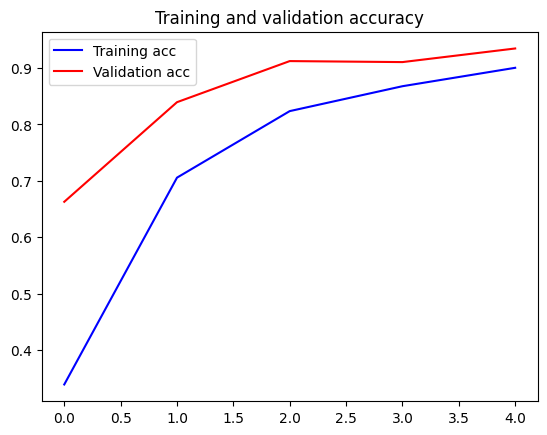

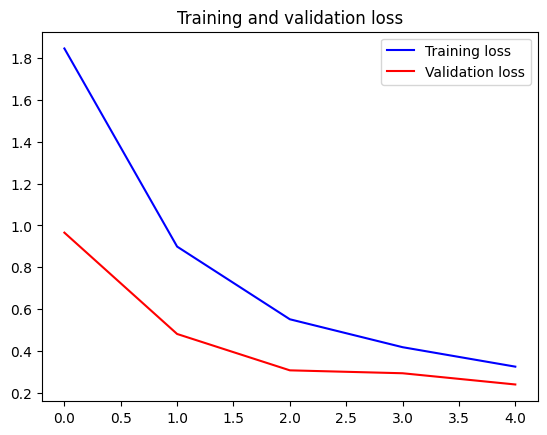

In [32]:
metrics_plot(history)

## 9- Classification error and accuracy for each class, and classification report

In [48]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = validation_datagen.flow_from_directory(
        directory= validation_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

# Get the true labels from the validation data generator
true_labels = test_generator.classes

# Predict the class probabilities for each sample
predicted_probs = model.predict(test_generator)

# Get the predicted class labels
predicted_labels = np.argmax(predicted_probs, axis=1)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Calculate accuracy for each class
class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

# Print class-wise accuracy
for i, acc in enumerate(class_accuracy):
    print(f"Accuracy for class {i}: {acc:.2f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels))


Found 4481 images belonging to 10 classes.
71/71 [==============================] - 40s 566ms/step
Accuracy for class 0: 0.97
Accuracy for class 1: 0.96
Accuracy for class 2: 0.95
Accuracy for class 3: 0.92
Accuracy for class 4: 0.94
Accuracy for class 5: 0.98
Accuracy for class 6: 0.86
Accuracy for class 7: 0.98
Accuracy for class 8: 0.86
Accuracy for class 9: 0.91

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.97      0.91       497
           1       0.98      0.96      0.97       453
           2       0.92      0.95      0.94       463
           3       0.99      0.92      0.95       469
           4       0.95      0.94      0.95       465
           5       0.97      0.98      0.97       462
           6       0.99      0.86      0.92       465
           7       0.91      0.98      0.94       400
           8       0.89      0.86      0.88       382
           9       0.90      0.91      0.91       425

    accurac

In [55]:
conf_matrix

array([[481,   0,   0,   1,   1,   0,   0,   2,   1,  11],
       [  2, 435,   9,   0,   0,   0,   0,   1,   1,   5],
       [  1,   4, 441,   0,   1,   2,   1,   8,   5,   0],
       [ 17,   0,   1, 432,   4,   0,   0,   1,   0,  14],
       [ 18,   0,   1,   1, 438,   2,   0,   1,   4,   0],
       [  3,   0,   0,   1,   0, 454,   1,   0,   0,   3],
       [ 10,   4,  20,   0,  13,   0, 398,   5,  15,   0],
       [  1,   0,   0,   0,   0,   1,   0, 391,   5,   2],
       [  7,   2,   7,   0,   3,   3,   2,  20, 330,   8],
       [ 15,   0,   0,   1,   1,   8,   0,   2,  11, 387]])

In [56]:
norm_conf_mat = conf_matrix / np.sum(conf_matrix, axis=1, keepdims=True)

In [58]:
norm_conf_mat = np.round(norm_conf_mat, 2)

## 10- Normalized Confusion Matrix for each of 10 Classes

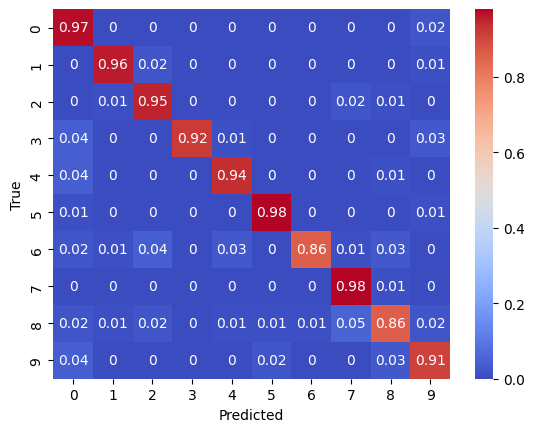

In [80]:
sns.heatmap(norm_conf_mat, annot=True, cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## 11- Saving model, data pipeline

In [60]:
# Save model architecture as JSON
model_json = model.to_json()
with open("model_architecture.json", "w") as json_file:
    json_file.write(model_json)

# Save model weights
model.save_weights("model_weights.h5")

# Load model architecture from JSON
with open("model_architecture.json", "r") as json_file:
    loaded_model_json = json_file.read()
loaded_model = model_from_json(loaded_model_json)

# Load model weights
loaded_model.load_weights("model_weights.h5")

# Save the loaded model as a .pkl file using joblib
joblib.dump(loaded_model, "saved_model.pkl")


['saved_model.pkl']

In [62]:
from google.colab import files

file_paths = ['saved_model.pkl', 'model_weights.h5', 'model_architecture.json']

for file_path in file_paths:
  files.download(file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [64]:
def preprocess_image(image):
    # Resize the image to the specified dimensions
    resized_image = cv2.resize(image, (480, 640))
    # Rescale pixel values to range [0, 1]
    rescaled_image = resized_image / 255.0
    return rescaled_image

# Create a pipeline
pipeline = Pipeline([
    ('preprocess', FunctionTransformer(preprocess_image, validate=False))
])

In [65]:
joblib.dump(pipeline, 'pipeline.pkl')

# Download the pipeline file
files.download('pipeline.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 12- Labeling unlabeled test images using my model

In [67]:
final_test_dir = '/content/imgs/test'
final_test_datagen = ImageDataGenerator(rescale=1./255)

final_test_generator = final_test_datagen.flow_from_directory(
        directory= validation_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)


# Predict the class probabilities for each sample
predicted_probs = model.predict(test_generator)


# Get the predicted class labels
predicted_labels = np.argmax(predicted_probs, axis=1)



Found 4481 images belonging to 10 classes.
71/71 [==============================] - 40s 556ms/step


## 13- Saving results as CSV file

In [70]:
# Labeling test data by model

label_dict = {
    0: 'c0: safe driving',
    1: 'c1: texting - right',
    2: 'c2: talking on the phone - right',
    3: 'c3: texting - left',
    4: 'c4: talking on the phone - left',
    5: 'c5: operating the radio',
    6: 'c6: drinking',
    7: 'c7: reaching behind',
    8: 'c8: hair and makeup',
    9: 'c9: talking to passenger'
}

mapped_labels = [label_dict[label] for label in predicted_labels]


In [78]:
test_dir = '/content/imgs/test'

data = []

for img_name, mapped_label in zip(os.listdir(test_dir), mapped_labels):

    # Append the image name and mapped label to the data list
    data.append((img_name, mapped_label))

# Create a DataFrame from the data list
df = pd.DataFrame(data, columns=['img_name', 'mapped_labels'])

df.to_csv('/content/test_data.csv', index=False)



In [79]:
df.head()

,img_name,mapped_labels
0,img_46333.jpg,c0: safe driving
1,img_63909.jpg,c0: safe driving
2,img_53125.jpg,c0: safe driving
3,img_14070.jpg,c0: safe driving
4,img_1026.jpg,c0: safe driving
